# Liquid freshwater content (pentad) in the SPNA and NSEA from ECCOv4r4

In [1]:
import numpy as np
import xarray as xr
import pandas as pd

import shapely
import geopandas as gpd
import salem

import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


### Load datasets

In [2]:
ecco = xr.open_dataset('/mnt/efs/data/ecco/eccov4r4_interp_salt.nc')

### Set spatial and temporal range

In [3]:
south = 45
north = 90
west = -110
east = 45

tstart = '1992-01-01'
tend = '2017-12-31'

In [4]:
psal = ecco.salinity.sel(time=slice(tstart,tend),lat=slice(south,north),lon=slice(west,east))

In [5]:
# psal_ref: baseline for computing anomalies
psal_ref = psal.sel(time=slice('1992-01-01','2002-12-31')).groupby('time.month').mean('time')

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [6]:
# Calculate monthly averages for each pentad timeframe
psal_9397 = psal.sel(time=slice('1993-01-01','1997-12-31')).groupby('time.month').mean('time')
psal_9802 = psal.sel(time=slice('1998-01-01','2002-12-31')).groupby('time.month').mean('time')
psal_0307 = psal.sel(time=slice('2003-01-01','2007-12-31')).groupby('time.month').mean('time')
psal_0812 = psal.sel(time=slice('2008-01-01','2012-12-31')).groupby('time.month').mean('time')
psal_1317 = psal.sel(time=slice('2013-01-01','2017-12-31')).groupby('time.month').mean('time')

In [7]:
# Calculate mean salinity for each pentad and combine to single data array
psal_pentad = xr.concat([psal_9397.mean('month'),psal_9802.mean('month'),psal_0307.mean('month'),
                         psal_0812.mean('month'),psal_1317.mean('month')], 'pentad')

In [8]:
# Calculate mean salinity anomaly for each pentad and combine to single data array
psal_pentad_anom = xr.concat([(psal_ref-psal_9397).mean('month'),(psal_ref-psal_9802).mean('month'),
                              (psal_ref-psal_0307).mean('month'),(psal_ref-psal_0812).mean('month'),
                              (psal_ref-psal_1317).mean('month')], 'pentad')

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


## Freshwater anomaly
The amount of dilution, $\Delta F$, for the water column at each gridpoint is evaluated from depth-averaged salinity differences relative to the baseline time period ($S – S_{ref}$) accumulated in discrete layers with height $dz$:
$$ \Delta F_{x,y} = \frac{\Delta S_{x,y}\;H_{x,y}}{S_{avg}}$$

where $\Delta S_{x,y}$ is
$$\Delta S_{x,y} = \frac{\sum{(S_{ref} - S)\,dz}}{\sum\,dz}$$

and $S_{avg}$ is the depth-averaged salinity for the water column with height $H_{x,y}$.

#### Water column heights

In [9]:
H = ((psal_pentad/psal_pentad)*ecco.dz).sum('depth')

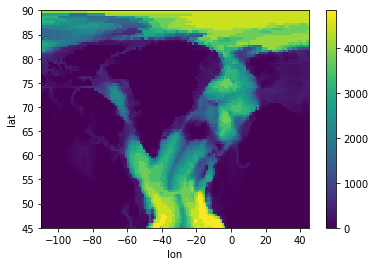

In [12]:
H[-1].plot()

#### Depth-averaged salinity

In [13]:
S_avg = (psal_pentad * ecco.dz).sum('depth')/H

#Hxy = ((psal_ref.mean('month')/psal_ref.mean('month'))*dz).sum('depth')
#S_avg = (psal_ref.mean('month') * dz).sum('depth')/Hxy

#### Depth-averaged salinity difference

In [14]:
dS = (psal_pentad_anom * ecco.dz).sum('depth')/H

#### Freshwater change ($\Delta F$)

In [15]:
dF = (dS*H)/S_avg

### Spatially integrate to obtain the liquid freshwater content (LFWC)
The volumetric census of freshwater anomalies (in km$^3$) is evaluated by integrating the area-weighted anomaly over the entire gridded domain:

$$\Delta F = \sum \Delta F_{x,y}\;dxdy $$

#### Define regions: Subpolar North Atlantic (`spna`) and Nordic Seas (`nsea`)

In [16]:
def get_gdf_patch(coords_patch):
    # Replace each pair of points by 10 points for projected map
    geometry = []
    segments = zip(coords_patch[:-2:2], coords_patch[1:-1:2], coords_patch[2::2], coords_patch[3::2])
    
    for line in [shapely.geometry.LineString([(x1, y1), (x2, y2)]) for (x1,y1,x2,y2) in segments]:
        for length in np.linspace(0,1,11):
            geometry.append( line.interpolate(length, normalized=True) )
        
    gdf_patch = gpd.GeoDataFrame([], geometry=geometry)
    
    # Convert Points to Polygo
    gdf_patch['geometry'] = gdf_patch['geometry'].apply(lambda x: x.coords[0])
    
    gdf_patch['shape_id'] = 0
    gdf_patch = gdf_patch.groupby('shape_id')['geometry'].apply(lambda x: shapely.geometry.Polygon(x.tolist())).reset_index()
    gdf_patch = gpd.GeoDataFrame(gdf_patch, geometry = 'geometry')
    
    # Salem uses this attribute:
    gdf_patch.crs = {'init': 'epsg:4326'}
    
    return gdf_patch

In [17]:
coords_spna = [-9.4, 50,-56.8, 50,-67.5, 62.3,-61.6, 66.7,-35, 66.7,-22.1, 66.1,-3.8, 59,-9.4, 50]
coords_nsea = [-3.8, 59,-22.1, 66.1,-35, 66.7,-29, 70,-25, 80,20, 80,20, 70,11, 64,5, 60,-3.8,59]

In [18]:
gdf_spna = get_gdf_patch(coords_spna)
gdf_nsea = get_gdf_patch(coords_nsea)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


### Region of interest (ROI)
All grid points outside the ROI will be masked out.

In [19]:
dF_spna = dF.salem.roi(shape=gdf_spna.loc[[0]])
dF_nsea = dF.salem.roi(shape=gdf_nsea.loc[[0]])

/usr/local/lib/python3.6/dist-packages/salem/gis.py:66: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  out = pyproj.Proj(crs.to_proj4(), preserve_units=True)
/usr/local/lib/python3.6/dist-packages/salem/gis.py:66: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  out = pyproj.Proj(crs.to_proj4(), preserve_units=True)


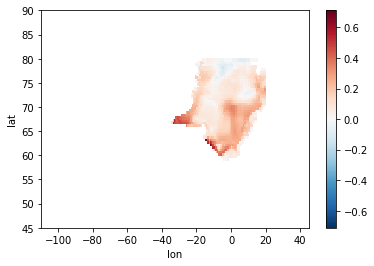

In [20]:
dF_nsea[0].plot()

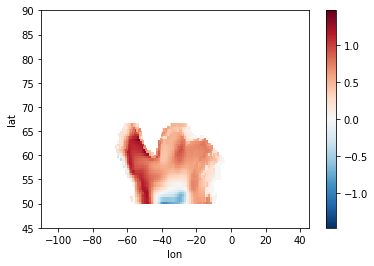

In [21]:
dF_spna[0].plot()

In [22]:
lfwc_spna = (dF_spna * ecco.area).sum(dim=['lat','lon'])
lfwc_nsea = (dF_nsea * ecco.area).sum(dim=['lat','lon'])

# Convert from m^3 to km^3
lfwc_spna = lfwc_spna*1e-9
lfwc_nsea = lfwc_nsea*1e-9

In [23]:
lfwc_spna = xr.DataArray(lfwc_spna.values,coords=[pd.date_range('1995-06-30','2015-06-30',freq='60M')],dims=['time'])
lfwc_nsea = xr.DataArray(lfwc_nsea.values,coords=[pd.date_range('1995-06-30','2015-06-30',freq='60M')],dims=['time'])

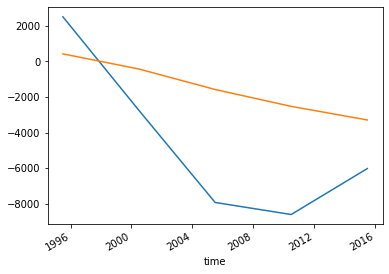

In [24]:
lfwc_spna.plot()
lfwc_nsea.plot()

In [25]:
ds_spna = lfwc_spna.to_dataset(name='lfwc')
ds_nsea = lfwc_nsea.to_dataset(name='lfwc')

In [26]:
ds_spna.to_netcdf('/mnt/efs/data/ecco/eccov4r4_lfwc_spna_pentad.nc', format='NETCDF4',
                  encoding={'lfwc':   {'zlib': True}})

In [27]:
ds_nsea.to_netcdf('/mnt/efs/data/ecco/eccov4r4_lfwc_nsea_pentad.nc', format='NETCDF4',
                  encoding={'lfwc':   {'zlib': True}})